# Logistic Regression (applied to dummy data)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


# Load data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/test/dummy_data.csv')
data

,1200,1300,1400,1500,1600,1700,code,label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta


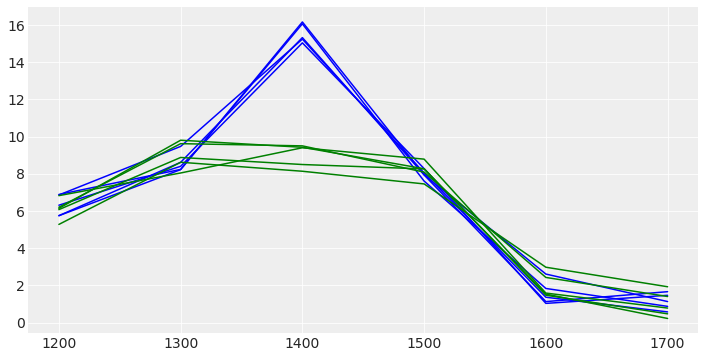

In [3]:
# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:-2], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

for i in range(len(data)):
    y_val = data.values[i]
    if y_val[-2] == 1:
        col = 'blue'
    else:
        col = 'green'
    plt.plot(x_val, y_val[:-2], '-', color=col);

In [4]:
# extract X data from dataframe
X = data.iloc[:,:-2].to_numpy()
X.shape

(10, 6)

In [5]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

(10,)

In [6]:
# add a column of ones to X
Xn = np.append(np.ones((X.shape[0],1)), X, axis=1)
Xn.shape

(10, 7)

# Model definition (Multiple Linear Regression)

In [7]:
# extract Y data from dataframe
Y = data.iloc[:,-2].to_numpy()
Y.shape

# standardize data
x_n = data.columns[:-2]
x_s = data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(10, 6)

In [8]:
with pm.Model() as model_mlr:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=0.5, shape=len(x_n))
    epsilon = pm.HalfNormal('epsilon', 10)
    
    mu = alpha + pm.math.dot(x_s, beta)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=Y)

    trace_mlr = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:20<00:00, 533.42draws/s]
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


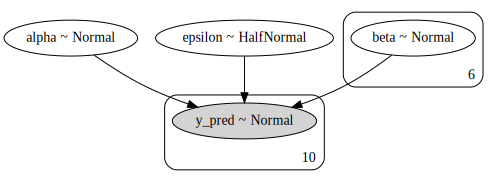

In [9]:
pm.model_to_graphviz(model_mlr)

# Model evaluation

In [10]:
az.summary(trace_mlr)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.501,0.083,1.354,1.652,0.001,0.001,6197.0,5593.0,7721.0,3508.0,1.0
beta[0],0.022,0.105,-0.182,0.220,0.001,0.001,7470.0,2723.0,8238.0,4454.0,1.0
beta[1],0.012,0.089,-0.151,0.183,0.001,0.001,8074.0,2282.0,8440.0,4222.0,1.0
beta[2],-0.475,0.110,-0.658,-0.253,0.002,0.001,5105.0,5105.0,5696.0,3295.0,1.0
beta[3],0.027,0.109,-0.174,0.243,0.001,0.002,5953.0,2401.0,6048.0,3842.0,1.0
beta[4],0.008,0.109,-0.204,0.206,0.001,0.001,6466.0,2866.0,6841.0,4252.0,1.0
beta[5],0.012,0.106,-0.202,0.206,0.001,0.001,7308.0,2797.0,7254.0,4681.0,1.0
epsilon,0.214,0.140,0.063,0.449,0.004,0.003,1229.0,1229.0,1090.0,1711.0,1.0


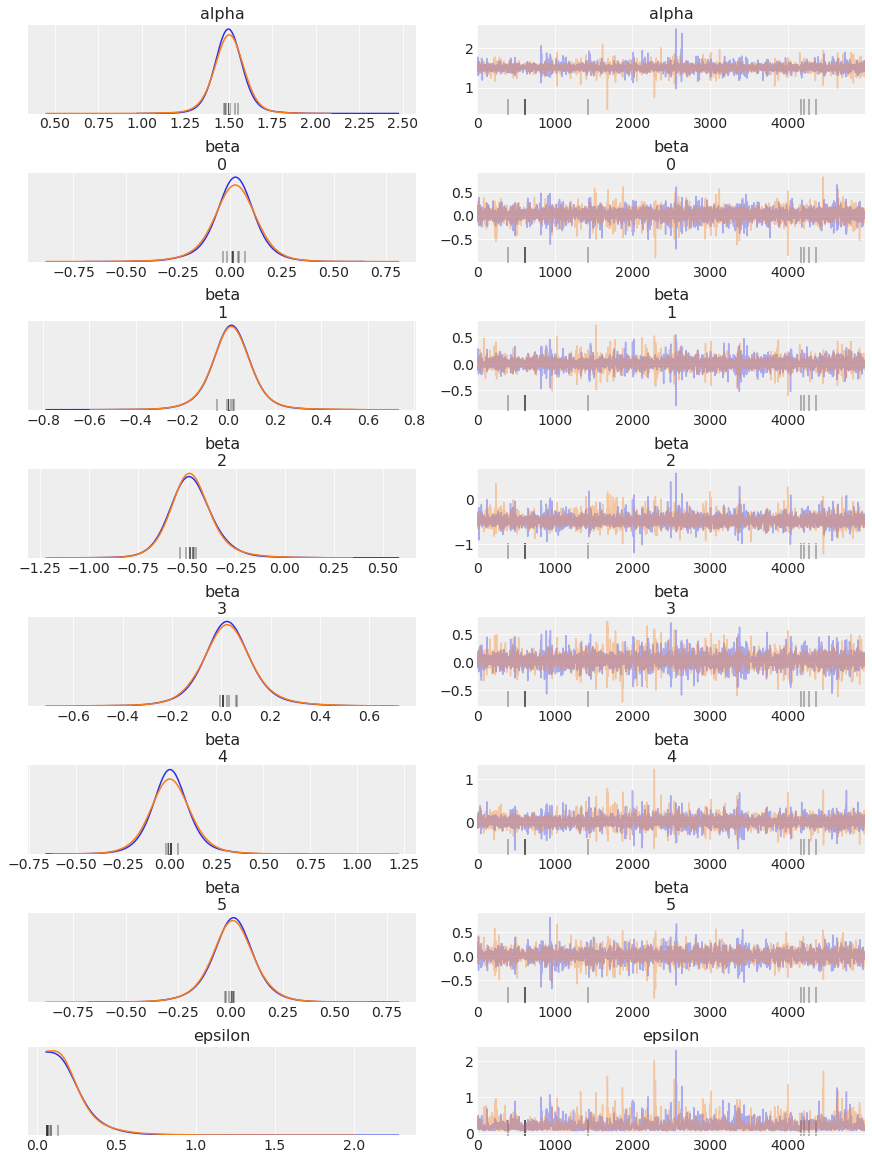

In [11]:
az.plot_trace(trace_mlr);

In [12]:
#az.plot_posterior(trace_mlr);

In [13]:
#az.plot_autocorr(trace_mlr);

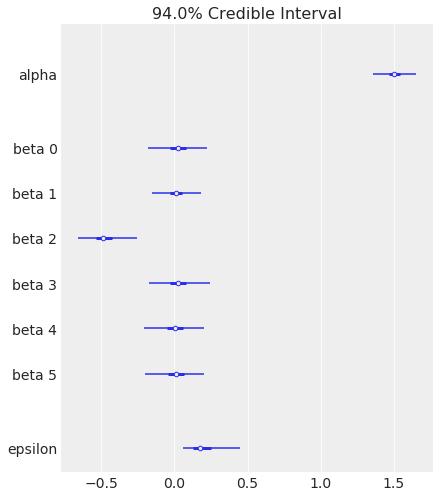

In [14]:
az.plot_forest(trace_mlr, combined=True);

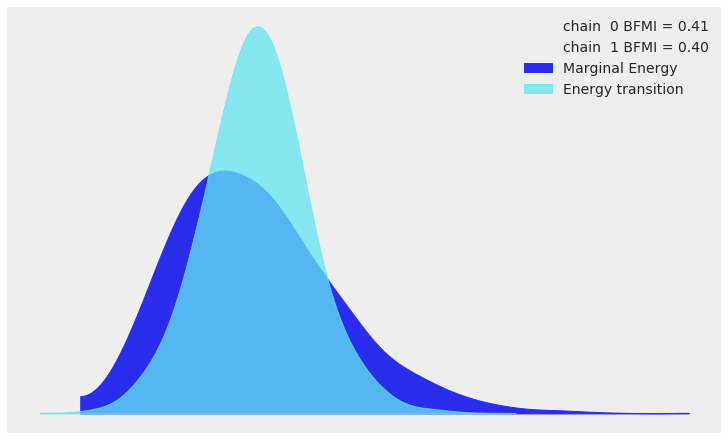

In [15]:
az.plot_energy(trace_mlr, figsize=(10, 6));

In [16]:
ppc = pm.sample_posterior_predictive(trace_mlr, samples=100, model=model_mlr)

100%|██████████| 100/100 [00:00<00:00, 414.60it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


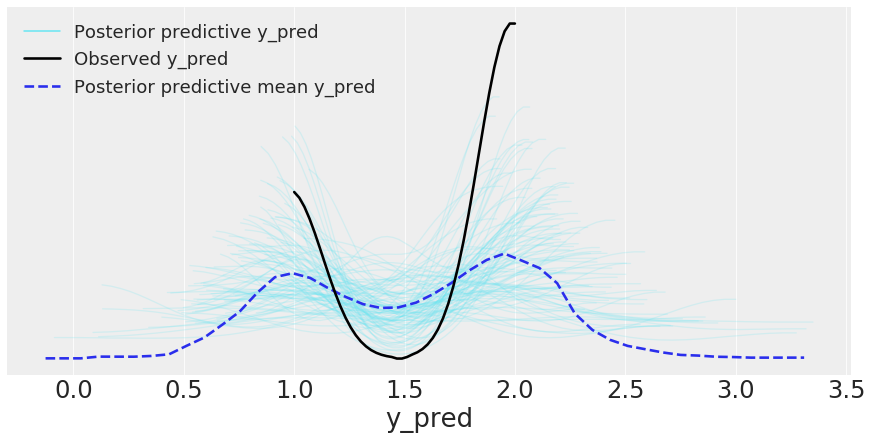

In [17]:
data_ppc = az.from_pymc3(trace=trace_mlr, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

# Model definition (Multiple Logistic Regression)

In [18]:
# standardize data
Y = pd.Categorical(data['label']).codes
x_n = data.columns[:-2]
x_s = data[x_n].values
x_s = (x_s - x_s.mean(axis=0)) / x_s.std(axis=0)
x_s.shape

(10, 6)

In [19]:
with pm.Model() as model_lr: 
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_s, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu))) 
     
    y_pred = pm.Bernoulli('y_pred', p=theta, observed=Y) 
 
    trace_lr = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:15<00:00, 316.57draws/s]


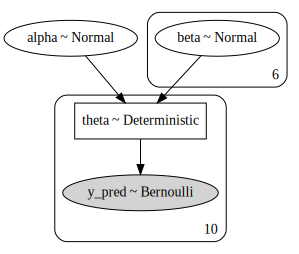

In [20]:
pm.model_to_graphviz(model_lr)

# Model evaluation

In [21]:
varnames = ['beta']
coef = az.summary(trace_lr, varnames)
coef

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta[0],-1.898,7.154,-15.707,11.010,0.173,0.123,1705.0,1705.0,1702.0,2102.0,1.0
beta[1],2.225,5.946,-8.663,14.051,0.151,0.107,1543.0,1530.0,1551.0,1900.0,1.0
beta[2],-19.688,6.506,-31.584,-7.927,0.180,0.129,1302.0,1274.0,1338.0,1968.0,1.0
beta[3],4.942,6.909,-7.754,17.833,0.179,0.126,1496.0,1496.0,1510.0,1854.0,1.0
beta[4],3.625,6.743,-9.382,15.849,0.173,0.124,1511.0,1473.0,1510.0,1817.0,1.0
beta[5],-0.782,7.130,-14.092,12.521,0.185,0.131,1488.0,1488.0,1495.0,2072.0,1.0


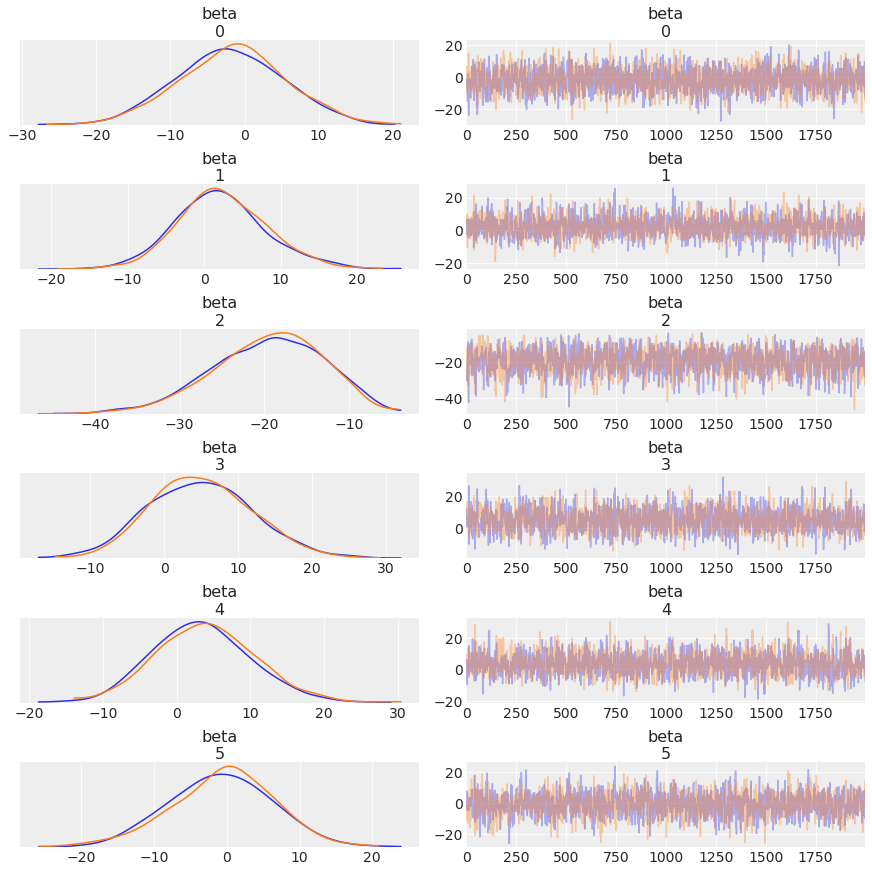

In [22]:
az.plot_trace(trace_lr, varnames);

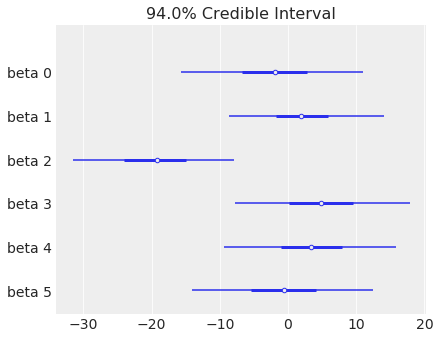

In [23]:
az.plot_forest(trace_lr, var_names=varnames, combined=True);

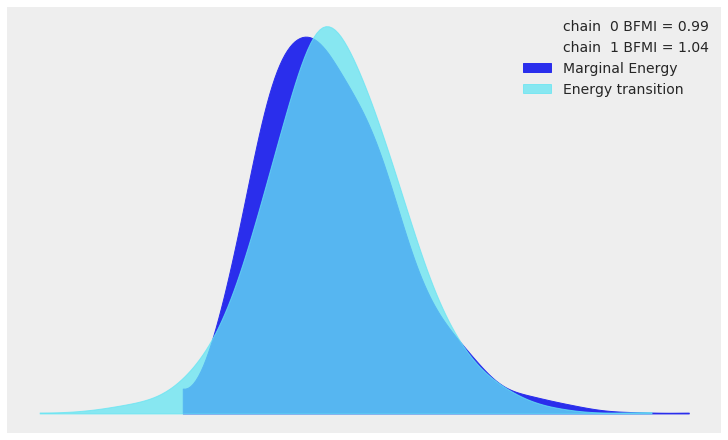

In [24]:
az.plot_energy(trace_lr, figsize=(10, 6));

In [25]:
# check predictions 
from scipy.special import expit as logistic

p_y = np.zeros(len(x_s))
lp = [] 

y_pred = trace_lr['theta'].mean(0)

for i in range(len(x_s)):
    if (y_pred[i] < 0.5): 
        p_y[i] = 0
        lp.append('Arabica')
    else:
        p_y[i] = 1
        lp.append('Robusta')

# add new colums to dataframe
data = data.assign(pred=pd.Series(p_y))
data = data.assign(pred_label=pd.Series(lp))
data

,1200,1300,1400,1500,1600,1700,code,label,pred,pred_label
0,6.859681,9.472035,15.243682,8.041220,1.359436,0.569499,1,Arabica,0.0,Arabica
1,6.309441,8.401346,15.041552,8.278361,1.028300,1.463044,1,Arabica,0.0,Arabica
2,5.746870,8.223710,16.166272,7.937323,1.125077,1.658064,1,Arabica,0.0,Arabica
3,6.884220,8.235310,16.066599,7.607464,1.831370,0.867443,1,Arabica,0.0,Arabica
4,5.746478,8.615229,15.325160,7.945671,2.605825,1.126482,1,Arabica,0.0,Arabica
5,5.276155,8.619932,8.136409,7.454639,2.973493,1.923625,2,Robusta,1.0,Robusta
6,6.138655,9.805064,9.425262,8.270688,1.467806,0.466879,2,Robusta,1.0,Robusta
7,6.072105,8.877384,8.498315,8.260295,1.528403,0.216872,2,Robusta,1.0,Robusta
8,6.200951,9.619839,9.501848,8.088760,2.424705,1.398675,2,Robusta,1.0,Robusta
9,6.823931,8.042763,9.400266,8.787564,1.583661,0.777459,2,Robusta,1.0,Robusta
